**PURPOSE**: To Build an XGBoost Regression model to predict the orbital period of Exoplanets from Lightcurve Data

**GOALS**:
Begin with the Initial List from EDA_ZERO script and take the following actions:

1. Train the Model on SIMULATED Exoplanet Lightcurve data, since there are not a sufficient number of actual Exoplanet curves for both training and evaluation.
2. Evaluate the performance of the Model against Real Preprocessed Kepler Exoplanet Lightcurves


**INPUTS:**
1. Features extracted using the **TSFRESH Library** for 10 thousand SIMULATED Lightcurve CSV files created using transit and stellar parameters from distributions fitted to actual Kepler Exoplanets.

2. ACTUAL Preprocessed Kepler Lightcurves for each member of the List of  Chosen Exoplanet Lightcurves.

**OUTPUTS**:
1. XGBoost Model
2. Evaluation of Model performance.
3. Discussion of Challenges and possible future directions.


In [1]:
###################################################################################
# XGBoost model for Orbital Prediction using Simulated Curves
###################################################################################
!pip install lightkurve astroquery pandas numpy tqdm  xgboost
!bash pip install --upgrade astroquery
!pip install stumpy
!pip install tsfresh
!pip install batman-package


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 106.6 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=e64234c6d127b3341fc81cb0dba6ba03deb477ad50eeaa09a75cdd41e6e89148
  Stored in directory: /root/.cache/pip/wheels/71/ae/f7/5b7e1e16a133d094431428169e9a8d9f750afe5459f0333c9b
  Created wheel for memoizatio

In [2]:
import os
import pandas as pd
import numpy as np
import lightkurve as lk
from lightkurve import LightCurve
#import batman
#import tsfresh
#from tsfresh import extract_features, select_features
#from tsfresh.utilities.dataframe_functions import impute
#import tsfel
#from tsfel import time_series_features_extractor, get_features_by_domain
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error




/usr/local/lib/python3.11/dist-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
#Define paths

ROOT  = Path("/content/drive/MyDrive/Berkeley_AIML/Capstone/lightcurves")
#EXOPLANET_INPUT_CURVES_PATH = ROOT / "chosen_exoplanet_curves"
SIMULATED_CURVES_PATH       = ROOT / "simulated_exoplanet_curves"
ANCILLARY                   = ROOT / "ancillary"
OUTPUT_PATH                 = ROOT / "orbital_prediction_simcurve_XGB_model1"

#os.makedirs(OUTPUT_PATH, exist_ok=True)
#os.makedirs(SIMULATED_CURVES_PATH, exist_ok=True)

In [11]:
features_filename = os.path.join(OUTPUT_PATH, 'simcurves_fitted_features2.csv')
#params_filename = os.path.join('sample_data/simcurves2_params_10k.csv')
params_df =pd.read_csv(params_filename)
features_df =pd.read_csv(features_filename)

# Obtain the Target Value (Orbital Period) for the y-variable from the params_df file by merging on planet_name
merged_df = pd.merge(features_df, params_df[['planet_name', 'period']], on='planet_name', how='inner')
print(f'Length of features_df: {len(features_df)}')
print(f'Length of params_df: {len(params_df)}')
print(f'Length of merged_df: {len(merged_df)}')

Length of features_df: 10000
Length of params_df: 10000
Length of merged_df: 10000


In [ ]:
# Control the Maximum values of orbital values used to train the model

In [19]:
def pred_eval_XGBModel(model, input_features, input_targets):
  # ----------------------------

  #  Log-transform target (log1p avoids issues with 0)
  # ----------------------------
  y_pred_log = model.predict(input_features)
  y_true = input_targets
  y_pred = np.expm1(y_pred_log)
  # ----------------------------
  # Evaluate Metrics
  # ----------------------------
  r2 = r2_score(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

  print(f"R² Score: {r2:.4f}")
  print(f"MAE: {mae:.4f}")
  print(f"RMSE: {rmse:.4f}")
  print(f"MAPE: {mape:.2f}%")
  return  y_pred, y_true



In [20]:
def train_XGB_Model(X, y):
  X_train, X_val, y_train_raw, y_val_raw = train_test_split(X, y, test_size=0.2, random_state=42)

  # ----------------------------
  #  Log-transform target (log1p avoids issues with 0)
  # ----------------------------
  y_train = np.log1p(y_train_raw)
  y_val = np.log1p(y_val_raw)

  # ----------------------------
  # 3. Define and Train XGBoost Model
  # ----------------------------
  XGB_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
  XGB_model.fit(X_train, y_train)
# ----------------------------
# 4. Predict on validation set (still in log-space)
# ----------------------------
  y_pred, y_true = pred_eval_XGBModel(XGB_model,X_val, y_val_raw)
  return XGB_model, y_pred, y_true
# ----------------------------
# 5. Inverse-transform the predictions
# ----------------------------
  #y_pred = np.expm1(y_val_pred_log)   # expm1(log1p(x)) = x
  #y_true = y_val_raw.values


In [21]:
def visualize_predictions(y_true, y_pred, Title):
  # ----------------------------
  # 7. Visualization - Prediction vs True
  # ----------------------------
  plt.figure(figsize=(6, 6))
  plt.scatter(y_true, y_pred, alpha=0.5)
  plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
  plt.xlabel("True Orbital Period")
  plt.ylabel("Predicted Orbital Period")
  plt.title(Title )
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  # ----------------------------
  # 8. Residual Plot
  # ----------------------------
  residuals = y_true - y_pred
  plt.figure(figsize=(6, 4))
  plt.scatter(y_pred, residuals, alpha=0.5)
  plt.axhline(0, color='red', linestyle='--')
  plt.xlabel("Predicted Period")
  plt.ylabel("Residual (True - Predicted)")
  plt.title("Residuals vs Predicted")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  # ----------------------------
  # 9. Histogram of Errors
  # ----------------------------
  plt.figure(figsize=(6, 4))
  plt.hist(residuals, bins=30, color='gray', edgecolor='black')
  plt.xlabel("Prediction Error")
  plt.ylabel("Frequency")
  plt.title("Distribution of Residuals")
  plt.tight_layout()
  plt.show()
  return None

R² Score: 0.5891
MAE: 5.0942
RMSE: 36.2242
MAPE: 12.86%


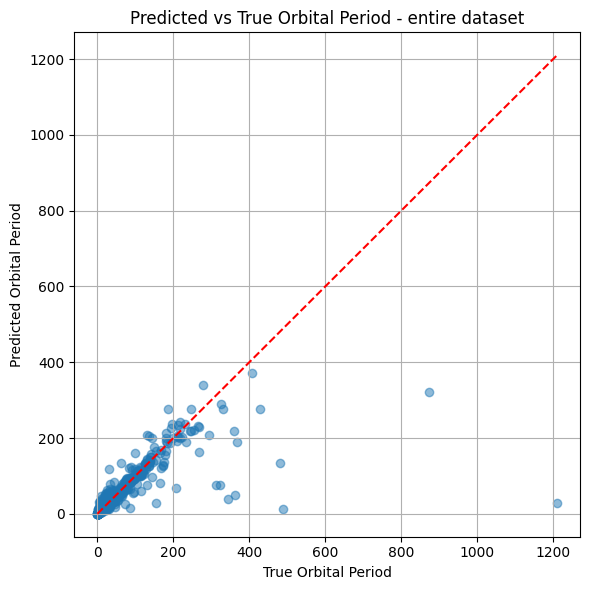

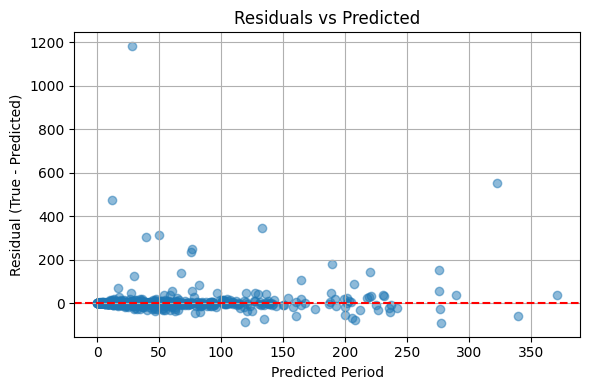

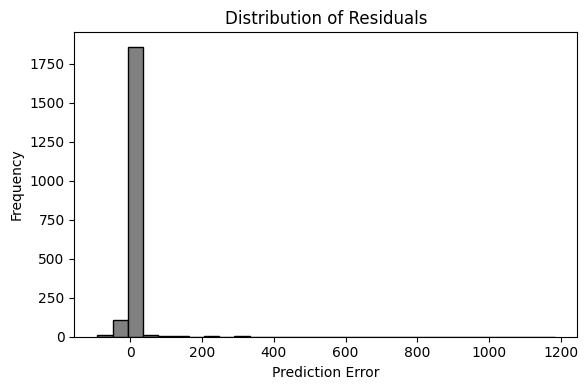

R² Score: 0.9570
MAE: 0.2167
RMSE: 0.5452
MAPE: 5.35%


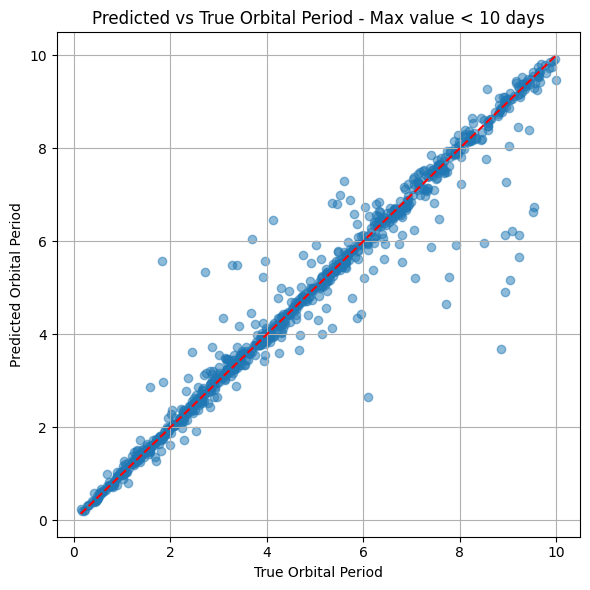

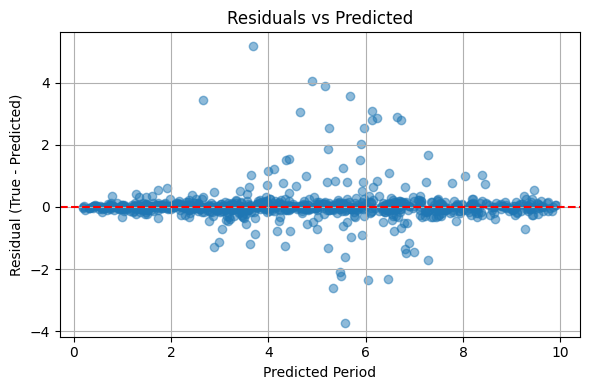

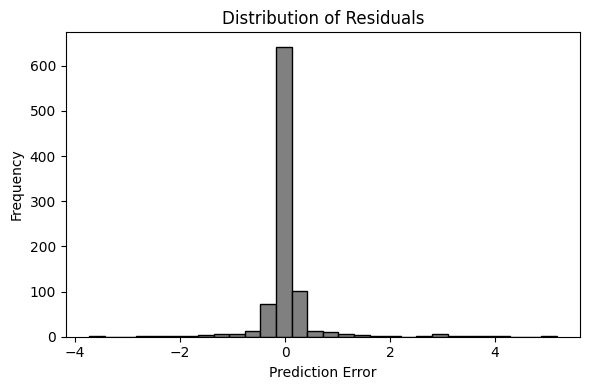

In [30]:
####################################################################################
# Train the model on simulated curves informed by fitted distributions from EDA_ZERO
####################################################################################


# Merge on planet_name
simulated_merged_df = pd.merge(features_df, params_df[['planet_name', 'period']], on='planet_name', how='inner')


# Extract X and y
X = simulated_merged_df.drop(columns=['planet_name', 'period'])
y = simulated_merged_df['period']
#print(X.dtypes)
trained_model, y_pred, y_true = train_XGB_Model(X, y)
visualize_predictions(y_true, y_pred, "Predicted vs True Orbital Period - entire dataset")

# 2nd Round only using data for which Orbital Period is below 10 days
simulated_merged_df = simulated_merged_df[simulated_merged_df['period'] < 10]

# Extract X and y
X = simulated_merged_df.drop(columns=['planet_name', 'period'])
y = simulated_merged_df['period']
#print(X.dtypes)
trained_model, y_pred, y_true = train_XGB_Model(X, y)
visualize_predictions(y_true, y_pred, "Predicted vs True Orbital Period - Max value < 10 days")


**TAKEAWAY**: The Model performs best when it is trained only datasets where the target(value of Orbital Period) is not more than 10 days

In [ ]:
# Prepare Actual Kepler Data for consumption by XGBoost
        lc = LightCurve(time=df['time'].values, flux=df['flux'].values)
        lc = lc.remove_nans()
        lc = lc.flatten(window_length=401, sigma=2)
        lc = lc.remove_outliers(sigma=5)
        #print("           About to normalize")
        lc = lc.normalize().remove_nans()
        #print("           About to fill gaps")
        lc_filled = lc.fill_gaps()


Length of features_df: 814
Length of params_df: 1406
Length of merged_df BEFORE filtration: 799
Length of merged_df AFTER filtration: 383
R² Score: -0.5175
MAE: 2.5315
RMSE: 3.0671
MAPE: 117.24%


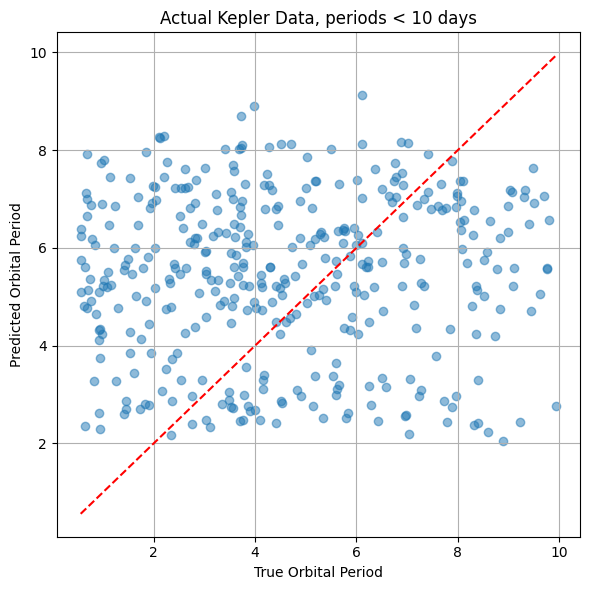

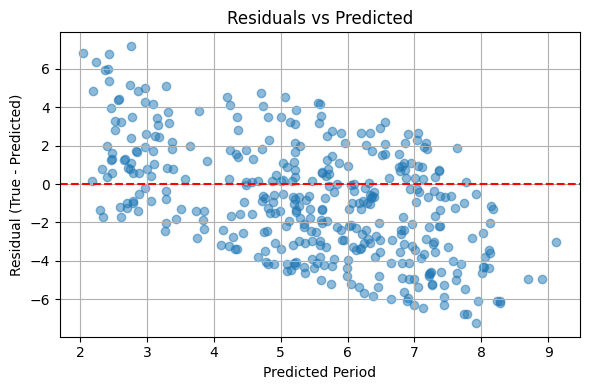

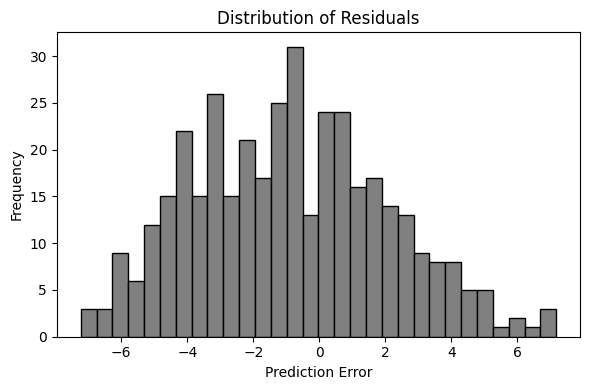

In [25]:
# Predict Orbital Period against Actual Kepler Data
###################################################
kepler_features_filename = os.path.join(OUTPUT_PATH, 'kepler_clean_curve_tsfresh_features.csv')
kepler_features_df =pd.read_csv(kepler_features_filename)
kepler_periods_filename = os.path.join(OUTPUT_PATH, 'selected_exoplanets.csv')
kepler_periods_df =pd.read_csv(kepler_periods_filename)
kepler_periods_df = kepler_periods_df.rename(columns={'pl_name': 'planet_name'})
#kepler_features_df.head()

print(f'Length of features_df: {len(kepler_features_df)}')
print(f'Length of params_df: {len(kepler_periods_df)}')

merged_df = pd.merge(kepler_features_df, kepler_periods_df[['planet_name', 'pl_orbper']], on='planet_name', how='inner')
print(f'Length of merged_df BEFORE filtration: {len(merged_df)}')
merged_df = merged_df[merged_df['pl_orbper'] < 10]
print(f'Length of merged_df AFTER filtration: {len(merged_df)}')

X = merged_df.drop(columns=['planet_name', 'pl_orbper'])
y = merged_df['pl_orbper']
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')
#print(X.dtypes)
y_pred, y_true  = pred_eval_XGBModel(trained_model,X, y)
visualize_predictions(y_true, y_pred, "Actual Kepler Data, periods < 10 days")

TAKEAWAY: The Model suffers from OVERFITTING, giving very good performance on the Test Set (consisting of simulated lightcurves), but performance is poor on actual lightcurve data.

POSSIBLE NEXT STEPS to overcome this challenge:

In [28]:
##############################
# Try Regularization
##############################
def train_XGB_Model_regularized(X, y):
  X_train, X_val, y_train_raw, y_val_raw = train_test_split(X, y, test_size=0.2, random_state=42)

  # ----------------------------
  #  Log-transform target (log1p avoids issues with 0)
  # ----------------------------
  y_train = np.log1p(y_train_raw)
  y_val = np.log1p(y_val_raw)

  # ----------------------------
  # 3. Define and Train XGBoost Model
  # ----------------------------

  XGB_model = XGBRegressor(n_estimators=100,max_depth=4, reg_lambda=1, alpha=0.1, min_child_weight=5)
  XGB_model.fit(X_train, y_train)
# ----------------------------
# 4. Predict on validation set (still in log-space)
# ----------------------------
  y_pred, y_true = pred_eval_XGBModel(XGB_model,X_val, y_val_raw)
  return XGB_model, y_pred, y_true
# ----------------------------
# 5. Inverse-transform the predictions
# ----------------------------
  #y_pred = np.expm1(y_val_pred_log)   # expm1(log1p(x)) = x
  #y_true = y_val_raw.values







R² Score: 0.9549
MAE: 0.2657
RMSE: 0.5583
MAPE: 7.13%


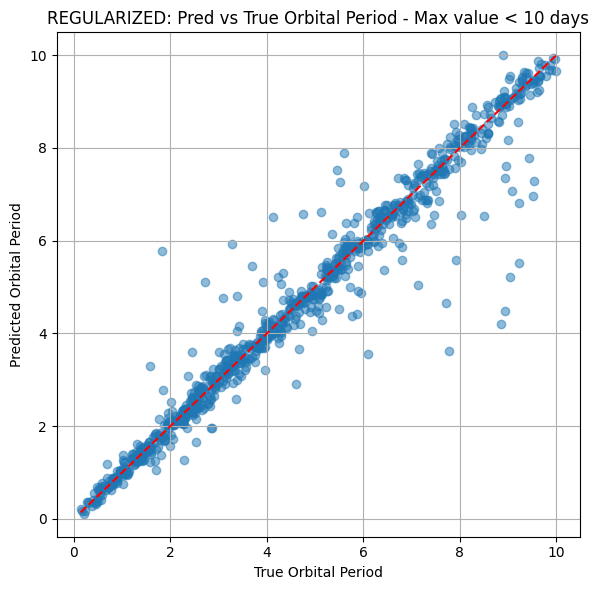

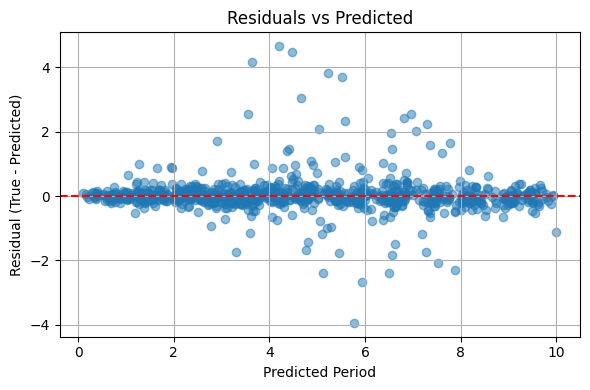

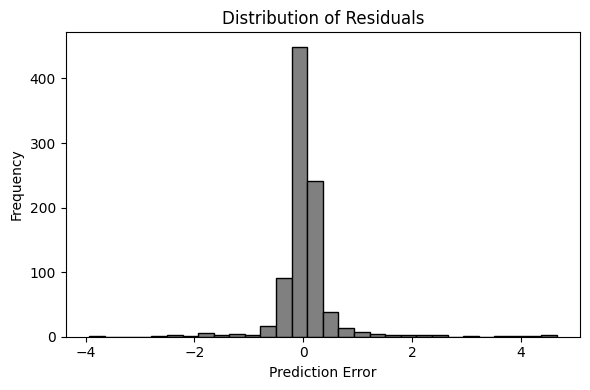

In [33]:
#Train with regularization
simulated_merged_df = simulated_merged_df[simulated_merged_df['period'] < 10]
# Extract X and y
X = simulated_merged_df.drop(columns=['planet_name', 'period'])
y = simulated_merged_df['period']
#print(X.dtypes)
trained_model_regularized, y_pred, y_true = train_XGB_Model_regularized(X, y)
visualize_predictions(y_true, y_pred, "REGULARIZED: Pred vs True Orbital Period - Max value < 10 days")

Length of features_df: 814
Length of params_df: 1406
Length of merged_df BEFORE filtration: 799
Length of merged_df AFTER filtration: 383
R² Score: -1.7360
MAE: 3.4025
RMSE: 4.1184
MAPE: 164.02%


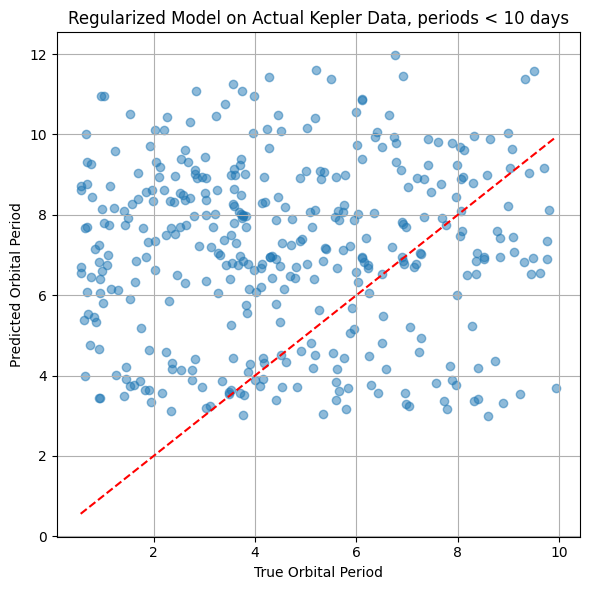

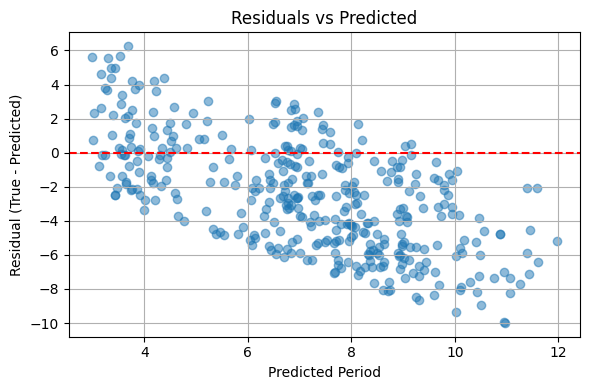

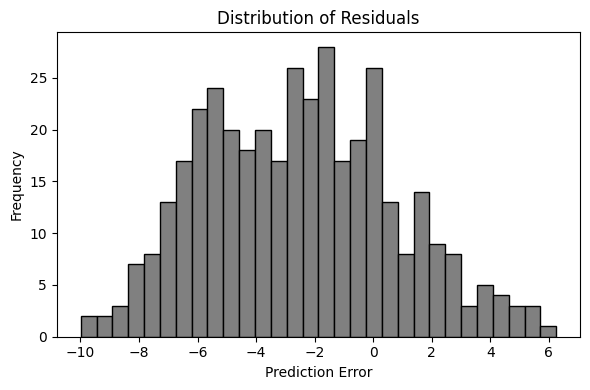

In [35]:
# Now Test performance of the Regularized Version
# against Actual Kepler Data
###################################################
kepler_features_filename = os.path.join(OUTPUT_PATH, 'kepler_clean_curve_tsfresh_features.csv')
kepler_features_df =pd.read_csv(kepler_features_filename)
kepler_periods_filename = os.path.join(OUTPUT_PATH, 'selected_exoplanets.csv')
kepler_periods_df =pd.read_csv(kepler_periods_filename)
kepler_periods_df = kepler_periods_df.rename(columns={'pl_name': 'planet_name'})
#kepler_features_df.head()

print(f'Length of features_df: {len(kepler_features_df)}')
print(f'Length of params_df: {len(kepler_periods_df)}')

merged_df = pd.merge(kepler_features_df, kepler_periods_df[['planet_name', 'pl_orbper']], on='planet_name', how='inner')
print(f'Length of merged_df BEFORE filtration: {len(merged_df)}')
merged_df = merged_df[merged_df['pl_orbper'] < 10]
print(f'Length of merged_df AFTER filtration: {len(merged_df)}')

X = merged_df.drop(columns=['planet_name', 'pl_orbper'])
y = merged_df['pl_orbper']
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')
#print(X.dtypes)
y_pred, y_true  = pred_eval_XGBModel(trained_model_regularized,X, y)
visualize_predictions(y_true, y_pred, "Regularized Model on Actual Kepler Data, periods < 10 days")

CONCLUSION: Regularization had a negative impact, raising the RMSE and MAPE

This strongly suggests that the Simulated Lightcurve data used to train the model is too different from Actual Kepler Data.

POSSIBLE NEXT STEPS/APPROACHES:

1. Adjust the distribution of parameters used to generate the simulated data to be more characteristic of the real Kepler Lightcurves.

2. The Noise added to the Simulated Lightcurves may need to more closely match the Signal-to-Noise metric of real Kepler Lightcurves, using the CDPP measure

3. Use the SMOTE library (Synthetic Minority Over-sampling Technique) to create Synthetic data that more closely matches real Kepler Lightcurves/